In [1]:
from gnomepy.backtest.backtest import *
from gnomepy.backtest.strategy import *
from gnomepy.backtest.archive.signal import *
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import numpy as np
import multiprocessing as mp
from gnomepy.backtest.coint_testing import *


### Testing Cointegration Strategies

#### Load in Data from Client

In [ ]:
client = MarketDataClient(bucket="gnome-market-data-dev", aws_profile_name="AWSAdministratorAccess-443370708724")
client_data_params = {
    "exchange_id": 1,
    "security_id": 1,
    "start_datetime": datetime.datetime(2025, 6, 7),
    "end_datetime": datetime.datetime(2025, 6, 8),
    "schema_type": SchemaType.MBP_10,
}
data = client.get_data(**client_data_params).to_df()
data.head()

#### Manufacture Synthetic Signals

/var/folders/xs/59kj_n6d2qs33ypnrkskvyzh0000gn/T/ipykernel_29069/3837775780.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data[f'bidPrice0_perturbed_{i}'].iloc[start_idx:start_idx+lag] = lagged_bid_price
/var/folders/xs/59kj_n6d2qs33y

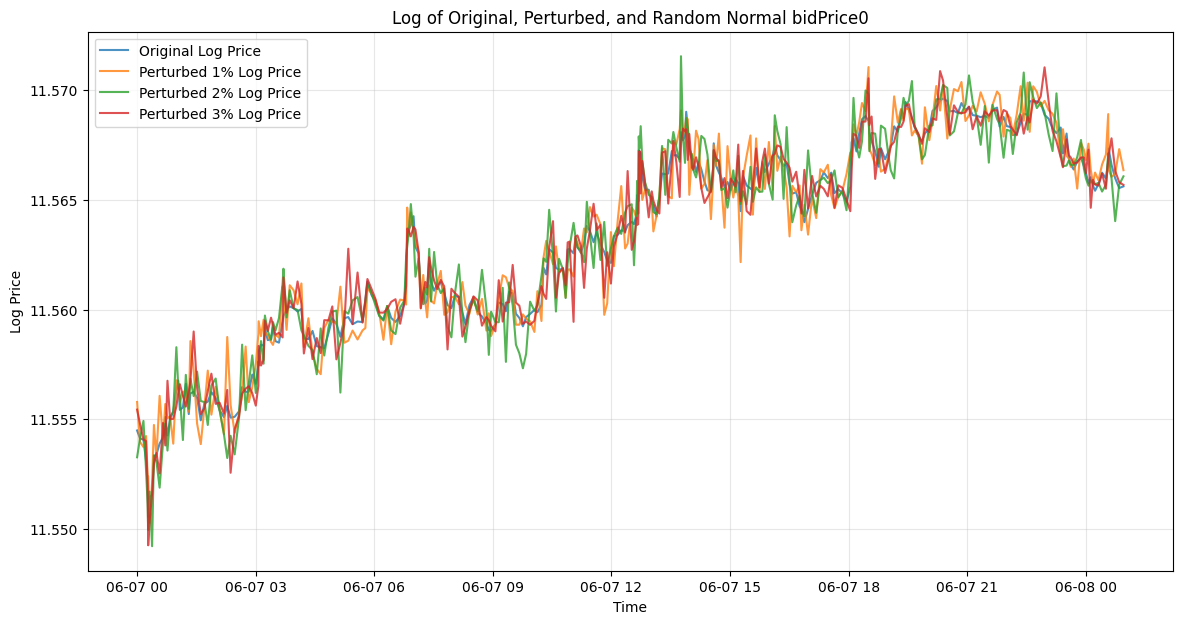

In [3]:
# Calculate average spread between ask and bid
avg_spread = (data['askPrice0'] - data['bidPrice0']).mean()

# Create lagged signals with different lag lengths
lag_lengths = [100, 200, 600]  # Short, medium and long lags
n = len(data)

# Initialize perturbed series with original prices (bidPrice0)
data['bidPrice0_perturbed_1'] = data['bidPrice0'] + np.random.normal(loc=0, scale=0.01, size=len(data)) * (data['bidPrice0']/10)
data['bidPrice0_perturbed_2'] = data['bidPrice0'] + np.random.normal(loc=0, scale=0.01, size=len(data)) * (data['bidPrice0']/10)
data['bidPrice0_perturbed_3'] = data['bidPrice0'] + np.random.normal(loc=0, scale=0.01, size=len(data)) * (data['bidPrice0']/10)

# Initialize perturbed ask prices by adding spread to perturbed bid prices
data['askPrice0_perturbed_1'] = data['bidPrice0_perturbed_1'] + avg_spread
data['askPrice0_perturbed_2'] = data['bidPrice0_perturbed_2'] + avg_spread
data['askPrice0_perturbed_3'] = data['bidPrice0_perturbed_3'] + avg_spread

# --- New: Create random normal walk and its perturbed versions ---
# Create a random walk series
data['bidPrice0_random_normal'] = np.cumsum(np.random.normal(size=len(data))) + 10000
data['askPrice0_random_normal'] = data['bidPrice0_random_normal'] + avg_spread

# Initialize perturbed versions of the random walk
data['bidPrice0_random_normal_perturbed_1'] = data['bidPrice0_random_normal'] + np.random.normal(loc=0, scale=0.01, size=len(data)) * (data['bidPrice0_random_normal']/10)
data['bidPrice0_random_normal_perturbed_2'] = data['bidPrice0_random_normal'] + np.random.normal(loc=0, scale=0.01, size=len(data)) * (data['bidPrice0_random_normal']/10)
data['bidPrice0_random_normal_perturbed_3'] = data['bidPrice0_random_normal'] + np.random.normal(loc=0, scale=0.01, size=len(data)) * (data['bidPrice0_random_normal']/10)

# Initialize random_normal_perturbed ask prices by adding spread to random_normal_perturbed bid prices
data['askPrice0_random_normal_perturbed_1'] = data['bidPrice0_random_normal_perturbed_1'] + avg_spread
data['askPrice0_random_normal_perturbed_2'] = data['bidPrice0_random_normal_perturbed_2'] + avg_spread
data['askPrice0_random_normal_perturbed_3'] = data['bidPrice0_random_normal_perturbed_3'] + avg_spread

# Generate random lag points for each series
num_lags = n // 1000  # Create lags roughly every 1000 ticks
lag_points = np.sort(np.random.choice(range(n-max(lag_lengths)), num_lags, replace=False))

# Apply lags at random points for both bidPrice0 and bidPrice0_random_normal perturbed series
for start_idx in lag_points:
    # For each lag length (short, medium, long)
    for i, lag in enumerate(lag_lengths, 1):
        # --- For bidPrice0 perturbed series ---
        lagged_bid_price = data['bidPrice0'].iloc[start_idx-lag:start_idx-lag+lag].values
        lagged_ask_price = lagged_bid_price + avg_spread
        data[f'bidPrice0_perturbed_{i}'].iloc[start_idx:start_idx+lag] = lagged_bid_price
        data[f'askPrice0_perturbed_{i}'].iloc[start_idx:start_idx+lag] = lagged_ask_price

        # --- For bidPrice0_random_normal perturbed series (bid and ask) ---
        lagged_random_normal_bid = data['bidPrice0_random_normal'].iloc[start_idx-lag:start_idx-lag+lag].values
        lagged_random_normal_ask = lagged_random_normal_bid + avg_spread
        data[f'bidPrice0_random_normal_perturbed_{i}'].iloc[start_idx:start_idx+lag] = lagged_random_normal_bid
        data[f'askPrice0_random_normal_perturbed_{i}'].iloc[start_idx:start_idx+lag] = lagged_random_normal_ask


# Create divergent versions of bidPrice0_perturbed_1,2,3 and their corresponding ask prices, but add funky noise to the entire series
for i in range(1, 4):
    base_col = f'bidPrice0_perturbed_{i}'
    new_bid_col = f'bidPrice0_perturbed_{i}_divergent'
    new_ask_col = f'askPrice0_perturbed_{i}_divergent'
    n = len(data)
    split_idx = int(n * 0.55)
    base_price = data[base_col].iloc[split_idx]
    base_magnitude = 0.000001 * base_price

    # --- Funky noise: sum of sinusoids with random frequencies, plus some random walk ---
    t = np.arange(n)
    num_sines = 3
    funky_noise = np.zeros(n)
    for j in range(num_sines):
        freq = np.random.uniform(0.0005, 0.005)
        phase = np.random.uniform(0, 2 * np.pi)
        amplitude = np.random.uniform(0.0005, 0.002) * data[base_col].mean()
        funky_noise += amplitude * np.sin(2 * np.pi * freq * t + phase)
    # Add a small random walk component
    funky_noise += np.cumsum(np.random.standard_t(df=3, size=n)) * (0.00005 * data[base_col].mean())

    data[new_bid_col] = data[base_col] + funky_noise

    # --- Exponential divergent sections after split_idx, with sign flips at random intervals ---
    min_seg_len = int(0.05 * n)
    max_seg_len = int(0.15 * n)
    idx = split_idx
    trend_sign = 1 if i % 2 == 1 else -1
    exp_trend = np.zeros(n - split_idx)
    pos = 0
    while idx < n:
        seg_len = np.random.randint(min_seg_len, max_seg_len + 1)
        seg_end = min(idx + seg_len, n)
        steps = np.arange(seg_end - idx)
        # Exponential divergence: exp(a * step) - 1, with small a
        a = trend_sign * np.random.uniform(0.00005, 0.00015)
        exp_trend[pos:pos + len(steps)] = base_magnitude * (np.exp(a * steps) - 1)
        trend_sign *= -1
        idx = seg_end
        pos += len(steps)
    # Add the piecewise exponential trend to the series after split_idx
    data.loc[data.index[split_idx:], new_bid_col] += exp_trend

    # Create the corresponding ask price using avg_spread
    data[new_ask_col] = data[new_bid_col] + avg_spread

    # Calculate and store the log of the divergent bid price
    data[f'log_price_perturbed_{i}_divergent'] = np.log(data[new_bid_col])

# Calculate log of prices
data['log_price'] = np.log(data['bidPrice0'])
data['log_price_perturbed_1'] = np.log(data['bidPrice0_perturbed_1'])
data['log_price_perturbed_2'] = np.log(data['bidPrice0_perturbed_2'])
data['log_price_perturbed_3'] = np.log(data['bidPrice0_perturbed_3'])

# Also calculate log of random normal and its perturbed versions
data['log_price_random_normal'] = np.log(data['bidPrice0_random_normal'])
data['log_price_random_normal_perturbed_1'] = np.log(data['bidPrice0_random_normal_perturbed_1'])
data['log_price_random_normal_perturbed_2'] = np.log(data['bidPrice0_random_normal_perturbed_2'])
data['log_price_random_normal_perturbed_3'] = np.log(data['bidPrice0_random_normal_perturbed_3'])

# Drop NaN values from all columns used in plotting
data = data.dropna(subset=[
    'log_price', 'log_price_perturbed_1', 'log_price_perturbed_2', 'log_price_perturbed_3',
    'log_price_random_normal', 'log_price_random_normal_perturbed_1', 'log_price_random_normal_perturbed_2', 'log_price_random_normal_perturbed_3'
], axis=0)

# Display the log prices, plotting every 1000th point
plt.figure(figsize=(14, 7))
plt.plot(data['timestampEvent'][::1000], data['log_price'][::1000], label='Original Log Price', alpha=0.8)
plt.plot(data['timestampEvent'][::1000], data['log_price_perturbed_1'][::1000], label='Perturbed 1% Log Price', alpha=0.8)
plt.plot(data['timestampEvent'][::1000], data['log_price_perturbed_2'][::1000], label='Perturbed 2% Log Price', alpha=0.8)
plt.plot(data['timestampEvent'][::1000], data['log_price_perturbed_3'][::1000], label='Perturbed 3% Log Price', alpha=0.8)
# plt.plot(data['timestampEvent'][::1000], data['log_price_perturbed_1_divergent'][::1000], label='Perturbed 1% Log Price', alpha=0.8)
# plt.plot(data['timestampEvent'][::1000], data['log_price_perturbed_2_divergent'][::1000], label='Perturbed 2% Log Price', alpha=0.8)
# plt.plot(data['timestampEvent'][::1000], data['log_price_perturbed_3_divergent'][::1000], label='Perturbed 3% Log Price', alpha=0.8)
# plt.plot(data['timestampEvent'][::1000], data['log_price_random_normal'][::1000], label='Random Normal Log Price', alpha=0.8, linestyle='--')
# plt.plot(data['timestampEvent'][::1000], data['log_price_random_normal_perturbed_1'][::1000], label='Random Normal Perturbed 1', alpha=0.8, linestyle='--')
# plt.plot(data['timestampEvent'][::1000], data['log_price_random_normal_perturbed_2'][::1000], label='Random Normal Perturbed 2', alpha=0.8, linestyle='--')
# plt.plot(data['timestampEvent'][::1000], data['log_price_random_normal_perturbed_3'][::1000], label='Random Normal Perturbed 3', alpha=0.8, linestyle='--')
plt.xlabel('Time')
plt.ylabel('Log Price')
plt.title('Log of Original, Perturbed, and Random Normal bidPrice0')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

#### Find Cointegrated Baskets

In [ ]:
seen_baskets, cointegrated_baskets = get_coint_baskets(
    columns=[
        'bidPrice0', 'bidPrice0_perturbed_1', 'bidPrice0_perturbed_2', 'bidPrice0_perturbed_3',
        'bidPrice0_random_normal', 'bidPrice0_random_normal_perturbed_1', 'bidPrice0_random_normal_perturbed_2', 'bidPrice0_random_normal_perturbed_3'
            ], 
    data=data, significance_level=0.01, min_basket_size=2
)

Rank from test for basket ('bidPrice0', 'bidPrice0_perturbed_1', 'bidPrice0_perturbed_2', 'bidPrice0_perturbed_3', 'bidPrice0_random_normal', 'bidPrice0_random_normal_perturbed_1', 'bidPrice0_random_normal_perturbed_2', 'bidPrice0_random_normal_perturbed_3'): 8
Rank from test for basket ('bidPrice0', 'bidPrice0_perturbed_1', 'bidPrice0_perturbed_2'): 3
Added cointegrated basket: ('bidPrice0', 'bidPrice0_perturbed_1', 'bidPrice0_perturbed_2') with 3 eigenvector(s)
Rank from test for basket ('bidPrice0', 'bidPrice0_perturbed_1', 'bidPrice0_perturbed_2', 'bidPrice0_perturbed_3'): 4
Rank from test for basket ('bidPrice0', 'bidPrice0_perturbed_2', 'bidPrice0_perturbed_3'): 3
Added cointegrated basket: ('bidPrice0', 'bidPrice0_perturbed_2', 'bidPrice0_perturbed_3') with 3 eigenvector(s)
Rank from test for basket ('bidPrice0_random_normal', 'bidPrice0_random_normal_perturbed_1', 'bidPrice0_random_normal_perturbed_2'): 3
Added cointegrated basket: ('bidPrice0_random_normal', 'bidPrice0_random_

In [5]:
cointegrated_baskets

{('bidPrice0',
  'bidPrice0_perturbed_1',
  'bidPrice0_perturbed_2'): [array([ 1027.66652032, -1432.18696086,   403.91502454]), array([-1862.3347993 ,   377.31612528,  1484.70108835]), array([-2.19734083e+02,  3.78665500e-03,  5.79952047e-02])],
 ('bidPrice0',
  'bidPrice0_perturbed_2',
  'bidPrice0_perturbed_3'): [array([ 1338.24357503, -1533.59069481,   196.50482371]), array([-1771.10076967,   133.67522769,  1643.22605031]), array([-2.19882113e+02,  5.74785662e-02,  1.52874373e-01])],
 ('bidPrice0_random_normal',
  'bidPrice0_random_normal_perturbed_1',
  'bidPrice0_random_normal_perturbed_2'): [array([  919.13599298, -1334.61467215,   415.60726239]),
  array([-1359.96913994,   297.24967792,  1062.65443603]),
  array([-66.11740536,  -0.11704283,  -0.26500358])],
 ('bidPrice0_random_normal',
  'bidPrice0_random_normal_perturbed_2',
  'bidPrice0_random_normal_perturbed_3'): [array([  984.32832733, -1167.70163732,   184.02564967]),
  array([ 615.92117307,  -59.32264494, -558.38741663]),

#### Backtest Cointegration Baskets

In [ ]:
# Get basksets from cointegration testing
baskets = list(cointegrated_baskets.keys())

# Your setup code here
results = main(
    baskets=baskets,
    data=data,
    beta_refresh_freq=[1000, 10000, 100000],
    spread_window=[100, 1000, 10000],
    cash_start=[10000],
    notional=[100],
    trade_freq=[1],
    execution_delay=[0, 1, 2],
    enter_zscore=[2.0],
    exit_zscore=[0.3],
    use_multiprocessing=True
)
backtest_results = {params['id']: {'history_df': history_df, 'trade_log': trade_log, 'params': params}
                    for params, history_df, trade_log in results}


/Users/andrewannetrand/Desktop/gnomepy/gnomepy/backtest/coint_testing.py:211: RuntimeWarning: invalid value encountered in scalar divide
  z_scores[i] = (spreads[i] - spread_means[i]) / spread_stds[i]


Complete backtest of basket: ('bidPrice0', 'bidPrice0_perturbed_1', 'bidPrice0_perturbed_2') with params: beta_refresh_freq=100000, spread_window=100, cash_start=10000, notional=100, trade_freq=1, execution_delay=0, enter_zscore=2.0, exit_zscore=0.3
Complete backtest of basket: ('bidPrice0', 'bidPrice0_perturbed_1', 'bidPrice0_perturbed_2') with params: beta_refresh_freq=100000, spread_window=100, cash_start=10000, notional=100, trade_freq=5, execution_delay=0, enter_zscore=2.0, exit_zscore=0.3
Complete backtest of basket: ('bidPrice0', 'bidPrice0_perturbed_1', 'bidPrice0_perturbed_2') with params: beta_refresh_freq=100000, spread_window=100, cash_start=10000, notional=100, trade_freq=20, execution_delay=0, enter_zscore=2.0, exit_zscore=0.3
Complete backtest of basket: ('bidPrice0', 'bidPrice0_perturbed_1', 'bidPrice0_perturbed_2') with params: beta_refresh_freq=100000, spread_window=100, cash_start=10000, notional=100, trade_freq=100, execution_delay=0, enter_zscore=2.0, exit_zscore=0

/Users/andrewannetrand/Desktop/gnomepy/gnomepy/backtest/coint_testing.py:211: RuntimeWarning: invalid value encountered in scalar divide
  z_scores[i] = (spreads[i] - spread_means[i]) / spread_stds[i]


Complete backtest of basket: ('bidPrice0', 'bidPrice0_perturbed_1', 'bidPrice0_perturbed_2') with params: beta_refresh_freq=10000, spread_window=100, cash_start=10000, notional=100, trade_freq=5, execution_delay=0, enter_zscore=2.0, exit_zscore=0.3
Complete backtest of basket: ('bidPrice0', 'bidPrice0_perturbed_1', 'bidPrice0_perturbed_2') with params: beta_refresh_freq=1000, spread_window=100, cash_start=10000, notional=100, trade_freq=5, execution_delay=0, enter_zscore=2.0, exit_zscore=0.3
Complete backtest of basket: ('bidPrice0', 'bidPrice0_perturbed_1', 'bidPrice0_perturbed_2') with params: beta_refresh_freq=10000, spread_window=100, cash_start=10000, notional=100, trade_freq=20, execution_delay=0, enter_zscore=2.0, exit_zscore=0.3
Complete backtest of basket: ('bidPrice0', 'bidPrice0_perturbed_1', 'bidPrice0_perturbed_2') with params: beta_refresh_freq=10000, spread_window=100, cash_start=10000, notional=100, trade_freq=100, execution_delay=0, enter_zscore=2.0, exit_zscore=0.3
Co

/Users/andrewannetrand/Desktop/gnomepy/gnomepy/backtest/coint_testing.py:211: RuntimeWarning: invalid value encountered in scalar divide
  z_scores[i] = (spreads[i] - spread_means[i]) / spread_stds[i]


Complete backtest of basket: ('bidPrice0', 'bidPrice0_perturbed_2', 'bidPrice0_perturbed_3') with params: beta_refresh_freq=1000, spread_window=1000, cash_start=10000, notional=100, trade_freq=5, execution_delay=0, enter_zscore=2.0, exit_zscore=0.3
Complete backtest of basket: ('bidPrice0', 'bidPrice0_perturbed_2', 'bidPrice0_perturbed_3') with params: beta_refresh_freq=1000, spread_window=1000, cash_start=10000, notional=100, trade_freq=20, execution_delay=0, enter_zscore=2.0, exit_zscore=0.3
Complete backtest of basket: ('bidPrice0', 'bidPrice0_perturbed_2', 'bidPrice0_perturbed_3') with params: beta_refresh_freq=1000, spread_window=1000, cash_start=10000, notional=100, trade_freq=100, execution_delay=0, enter_zscore=2.0, exit_zscore=0.3
Complete backtest of basket: ('bidPrice0', 'bidPrice0_perturbed_2', 'bidPrice0_perturbed_3') with params: beta_refresh_freq=10000, spread_window=100, cash_start=10000, notional=100, trade_freq=1, execution_delay=0, enter_zscore=2.0, exit_zscore=0.3
C

#### Evaluate Cointegration Baskets

In [ ]:
backtest_results["('bidPrice0', 'bidPrice0_perturbed_1', 'bidPrice0_perturbed_2')_1000_1_100"]['trade_log']

,step,timestampEvent,last_beta_vector_refresh,action,before_cash,after_cash,price_vector,before_position,after_position,before_position_value,after_position_value,z_score,ticks_since_entry,pl
0,1001,2025-06-07 00:04:24.048,2025-06-07 00:04:23.945,enter_short,10000.000000,9979.047038,"[104208.0, 104336.77978322223, 104207.0]","[0.0, 0.0, 0.0]","[-0.00045290159211146226, -0.00017375457593292...",0.000000,20.952962,3.087114,0,-20.952962
1,1003,2025-06-07 00:04:25.057,2025-06-07 00:04:23.945,extend_short,9979.047038,9958.094077,"[104208.0, 104313.12575942259, 104207.0]","[-0.00045290159211146226, -0.00017375457593292...","[-0.0009058031842229245, -0.000347548552419184...",20.957072,41.910033,2.412351,1,-20.952962
2,1004,2025-06-07 00:04:25.108,2025-06-07 00:04:23.945,exit_short,9958.094077,10000.079212,"[104208.0, 104097.03625277046, 104207.0]","[-0.0009058031842229245, -0.000347548552419184...","[0.0, 0.0, 0.0]",41.985135,0.000000,-2.461019,3,41.985135
3,1005,2025-06-07 00:04:25.558,2025-06-07 00:04:23.945,enter_short,10000.079212,9979.126250,"[104208.0, 104301.3651896566, 104207.0]","[0.0, 0.0, 0.0]","[-0.00045290159211146226, -0.00017381357274160...",0.000000,20.952962,2.036063,0,-20.952962
4,1006,2025-06-07 00:04:25.625,2025-06-07 00:04:23.945,exit_short,9979.126250,10000.113616,"[104208.0, 104103.42535293466, 104207.0]","[-0.00045290159211146226, -0.00017381357274160...","[0.0, 0.0, 0.0]",20.987366,0.000000,-2.211185,1,20.987366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33825,321531,2025-06-08 00:59:50.348,2025-06-08 00:57:10.085,exit_long,13467.702065,13412.803074,"[105431.0, 105511.02668496344, 105359.05610923...","[0.00037972484320082173, -3.4798007846854197e-...","[0.0, 0.0, 0.0]",-54.898991,0.000000,0.649302,1,-54.898991
33826,321543,2025-06-08 00:59:55.777,2025-06-08 00:57:10.085,enter_long,13412.803074,13467.996307,"[105431.0, 105412.24765837779, 105712.39537566...","[0.0, 0.0, 0.0]","[0.00037972484320082173, -3.476817414737157e-0...",0.000000,-55.193233,-2.479482,0,55.193233
33827,321544,2025-06-08 00:59:56.060,2025-06-08 00:57:10.085,exit_long,13467.996307,13413.153427,"[105431.0, 105499.02749873258, 105304.41764585...","[0.00037972484320082173, -3.476817414737157e-0...","[0.0, 0.0, 0.0]",-54.842879,0.000000,1.124434,1,-54.842879
33828,321548,2025-06-08 00:59:57.389,2025-06-08 00:57:10.085,enter_long,13413.153427,13468.346660,"[105431.0, 105346.79558003647, 105722.94703590...","[0.0, 0.0, 0.0]","[0.00037972484320082173, -3.478977565167503e-0...",0.000000,-55.193233,-2.469160,0,55.193233


In [17]:

import numpy as np

def compute_backtest_summary(history_df, trade_log):

    if trade_log.shape[0] == 0:
        return {
            'num_complete_trades': -1,
            'avg_profit_per_complete_trade': -1,
            'std_profit_per_complete_trade': -1,
            'total_profit': -1,
            'avg_ticks_per_complete_trade': -1,
            'std_ticks_per_complete_trade': -1,
            'win_ratio': -1,
            'max_drawdown': -1,
            'profit_factor': -1,
            'sharpe_ratio': -1
        }

    else:
        if 'after_cash' in trade_log.columns:
            trade_log['pl'] = trade_log['after_cash'] - trade_log['before_cash']

        else:
            print(trade_log)

        exit_trades = trade_log[trade_log['action'].str.contains('exit')]

        # Calculate max drawdown
        # Use the running maximum of after_cash to compute drawdown
        if 'after_cash' in trade_log.columns:
            running_max = trade_log['after_cash'].cummax()
            drawdown = trade_log['after_cash'] - running_max
            max_drawdown = drawdown.min()  # This will be negative or zero
        else:
            max_drawdown = np.nan

        # Calculate Sharpe ratio (using per-trade P&L)
        # If there are at least 2 trades, otherwise set to nan
        if len(exit_trades) > 1:
            mean_pl = exit_trades['pl'].mean()
            std_pl = exit_trades['pl'].std()
            sharpe_ratio = mean_pl / std_pl * np.sqrt(7257600) if std_pl != 0 else np.nan
        else:
            sharpe_ratio = np.nan

        summary = {
            'num_complete_trades': len(exit_trades),
            'avg_profit_per_complete_trade': exit_trades['pl'].mean(),
            'std_profit_per_complete_trade': exit_trades['pl'].std(),
            'total_profit': trade_log['pl'].sum(),
            'avg_ticks_per_complete_trade': exit_trades['ticks_since_entry'].mean(),
            'std_ticks_per_complete_trade': exit_trades['ticks_since_entry'].std(),
            'win_ratio': exit_trades[exit_trades['pl'] > 0].shape[0] / len(exit_trades),
            'max_drawdown': max_drawdown,
            'profit_factor': exit_trades[exit_trades['pl'] > 0]['pl'].sum() / np.abs(exit_trades[exit_trades['pl'] < 0]['pl'].sum() ),
            'sharpe_ratio': sharpe_ratio
        }

        return summary

# Generate summary statistics for each basket
backtest_summaries = {}
for basket, result in backtest_results.items():
    history_df = result['history_df']
    trade_log = result['trade_log']
    summary = compute_backtest_summary(history_df, trade_log)
    backtest_summaries[str(basket)] = summary

# Optionally, display as DataFrame for easy viewing
import pandas as pd
summary_df = pd.DataFrame.from_dict(backtest_summaries, orient='index')

# Round all float columns to 3 decimals for display
float_cols = summary_df.select_dtypes(include=['float', 'float64']).columns
summary_df[float_cols] = summary_df[float_cols].round(3)

from IPython.display import display
import pandas as pd

with pd.option_context('display.max_rows', None):
    display(summary_df.sort_values('sharpe_ratio', ascending=False))


/var/folders/xs/59kj_n6d2qs33ypnrkskvyzh0000gn/T/ipykernel_29069/944608088.py:55: RuntimeWarning: divide by zero encountered in scalar divide
  'profit_factor': exit_trades[exit_trades['pl'] > 0]['pl'].sum() / np.abs(exit_trades[exit_trades['pl'] < 0]['pl'].sum() ),


,num_complete_trades,avg_profit_per_complete_trade,std_profit_per_complete_trade,total_profit,avg_ticks_per_complete_trade,std_ticks_per_complete_trade,win_ratio,max_drawdown,profit_factor,sharpe_ratio
"('bidPrice0_random_normal', 'bidPrice0_random_normal_perturbed_1', 'bidPrice0_random_normal_perturbed_2')_10000_20_1000",254,0.257,0.083,65.487,1.689,1.125,1.000,-0.029,inf,8319.140
"('bidPrice0_random_normal', 'bidPrice0_random_normal_perturbed_1', 'bidPrice0_random_normal_perturbed_2')_10000_20_100",256,0.252,0.082,64.664,1.742,1.203,1.000,-0.029,inf,8289.905
"('bidPrice0_random_normal', 'bidPrice0_random_normal_perturbed_1', 'bidPrice0_random_normal_perturbed_2')_100000_1_1000",9323,0.259,0.096,2412.651,1.789,2.261,1.000,-0.140,inf,7227.404
"('bidPrice0', 'bidPrice0_perturbed_2', 'bidPrice0_perturbed_3')_10000_20_1000",317,0.218,0.082,69.066,1.713,1.095,1.000,-0.027,inf,7143.308
"('bidPrice0', 'bidPrice0_perturbed_2', 'bidPrice0_perturbed_3')_10000_20_100",318,0.215,0.084,68.234,1.698,1.287,1.000,-0.040,inf,6854.174
"('bidPrice0', 'bidPrice0_perturbed_1', 'bidPrice0_perturbed_2')_10000_20_1000",286,0.253,0.100,72.519,1.699,1.173,1.000,-0.092,inf,6820.343
"('bidPrice0', 'bidPrice0_perturbed_1', 'bidPrice0_perturbed_2')_10000_20_100",278,0.254,0.102,70.147,1.647,1.060,1.000,-0.092,inf,6680.930
"('bidPrice0_random_normal', 'bidPrice0_random_normal_perturbed_1', 'bidPrice0_random_normal_perturbed_2')_1000_100_1000",91,0.244,0.104,22.317,1.912,1.314,1.000,-0.087,inf,6286.387
"('bidPrice0_random_normal', 'bidPrice0_random_normal_perturbed_1', 'bidPrice0_random_normal_perturbed_2')_1000_100_100",88,0.240,0.116,20.905,1.886,1.217,1.000,-0.142,inf,5582.019
"('bidPrice0', 'bidPrice0_perturbed_1', 'bidPrice0_perturbed_2')_100000_1_1000",10541,0.236,0.120,2491.817,1.668,1.652,0.993,-0.405,2356.535,5304.056


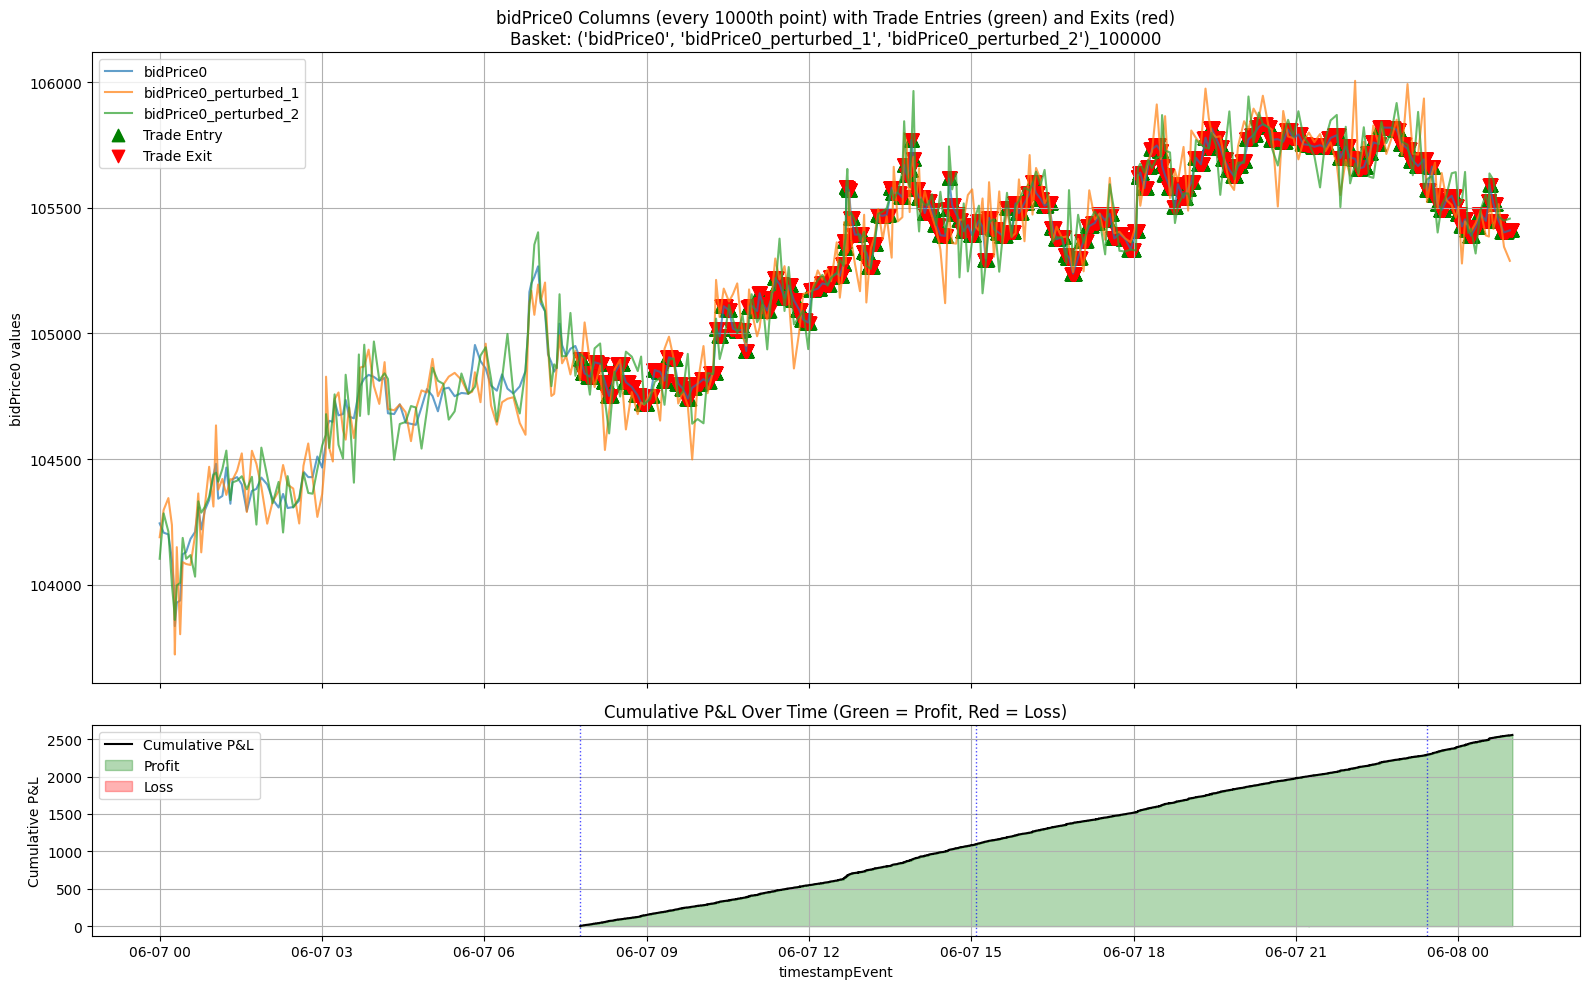

In [18]:
import matplotlib.pyplot as plt

def plot_bidprice0_and_trades(index):

    """
    Plots bidPrice0 columns and trade entries/exits for the basket at the given index in backtest_results.
    The basket key is included in the plot title.
    """
    # Get the basket's results at the given index
    basket_keys = list(backtest_results.keys())
    basket_key = basket_keys[index]
    result = backtest_results[basket_key]
    history_df = result['history_df']
    trade_log = result['trade_log']

    # Find all columns with "bidPrice0" in their name
    bid_cols = [col for col in history_df.columns if "bidPrice0" in col]

    # Plot every 1000th datapoint for all bidPrice0 columns against timestampEvent
    step = 1000
    sampled_idx = np.arange(0, len(history_df), step)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Plot bidPrice0 columns
    for col in bid_cols:
        ax1.plot(history_df['timestampEvent'].iloc[sampled_idx], history_df[col].iloc[sampled_idx], label=col, alpha=0.7)

    # Mark trade entries and exits (on the closest sampled timestamp)
    if trade_log is not None and not trade_log.empty:
        # Find entry and exit indices
        entry_mask = trade_log['action'].str.contains('enter', case=False)
        exit_mask = trade_log['action'].str.contains('exit', case=False)
        # For each entry/exit, find the closest sampled timestamp in history_df
        def get_closest_sampled_value(ts_list):
            # For each ts in ts_list, find the closest in sampled_idx
            values = []
            for ts in ts_list:
                # Find the index in history_df where timestampEvent == ts
                idx = history_df.index[history_df['timestampEvent'] == ts]
                if len(idx) == 0:
                    values.append(None)
                    continue
                idx = idx[0]
                # Find the closest sampled index
                closest_sampled = sampled_idx[np.abs(sampled_idx - idx).argmin()]
                values.append(history_df.loc[closest_sampled, bid_cols[0]])
            return values

        # Plot entry points
        ax1.scatter(
            trade_log.loc[entry_mask, 'timestampEvent'],
            get_closest_sampled_value(trade_log.loc[entry_mask, 'timestampEvent']),
            color='green', marker='^', s=80, label='Trade Entry'
        )
        # Plot exit points
        ax1.scatter(
            trade_log.loc[exit_mask, 'timestampEvent'],
            get_closest_sampled_value(trade_log.loc[exit_mask, 'timestampEvent']),
            color='red', marker='v', s=80, label='Trade Exit'
        )

    ax1.set_ylabel('bidPrice0 values')
    ax1.set_title(f'bidPrice0 Columns (every 1000th point) with Trade Entries (green) and Exits (red)\nBasket: {basket_key}')
    ax1.legend()
    ax1.grid(True)

    # Add vertical black dotted lines at timestamps where beta_refresh_vector_timestamp changes
    if 'last_beta_vector_refresh' in trade_log.columns:
        # Find where the value changes (including the first value)
        beta_refresh_ts = trade_log['last_beta_vector_refresh']
        change_mask = beta_refresh_ts != beta_refresh_ts.shift(1)
        change_indices = trade_log.index[change_mask]
        change_timestamps = trade_log.loc[change_indices, 'timestampEvent']
        for ts in change_timestamps:
            ax2.axvline(ts, color='blue', linestyle=':', linewidth=1, alpha=0.7, label='_nolegend_')

    # Fast and visually clear cumulative P&L area chart
    if trade_log is not None and not trade_log.empty:
        trade_log = trade_log.copy()
        trade_log['pl'] = trade_log['after_cash'] - trade_log['before_cash']
        trade_log['cum_pl'] = trade_log['pl'].cumsum()

        timestamps = trade_log['timestampEvent'].values
        cum_pl = trade_log['cum_pl'].values

        # Plot the cumulative P&L as a line
        ax2.plot(timestamps, cum_pl, color='black', linewidth=1.5, label='Cumulative P&L')

        # Fill area: green where cum_pl >= 0, red where cum_pl < 0
        ax2.fill_between(
            timestamps,
            cum_pl,
            0,
            where=(cum_pl >= 0),
            interpolate=True,
            color='green',
            alpha=0.3,
            label='Profit'
        )
        ax2.fill_between(
            timestamps,
            cum_pl,
            0,
            where=(cum_pl < 0),
            interpolate=True,
            color='red',
            alpha=0.3,
            label='Loss'
        )

        ax2.set_ylabel('Cumulative P&L')
        ax2.set_title('Cumulative P&L Over Time (Green = Profit, Red = Loss)')
        ax2.legend(loc='best')
        ax2.grid(True)

    ax2.set_xlabel('timestampEvent')
    plt.tight_layout()
    plt.show()

index = 2
plot_bidprice0_and_trades(index=index)

z_score mean: -0.002227011362850099
z_score std: 1.1264731408018493


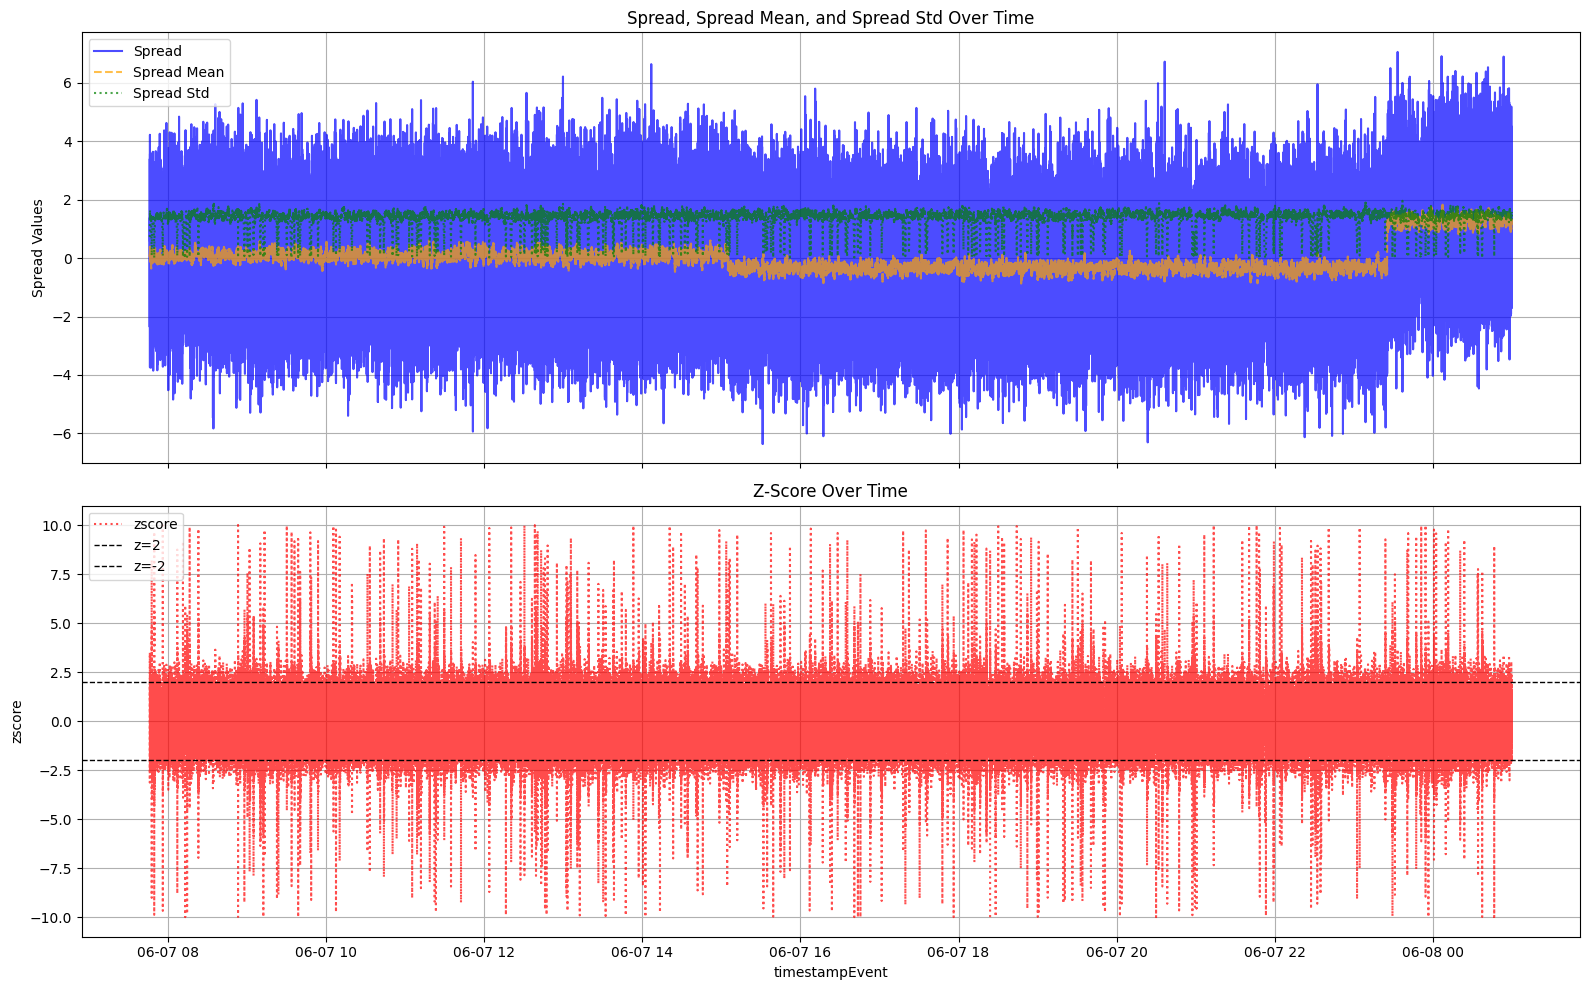

In [19]:
import matplotlib.pyplot as plt

def plot_spread_and_zscore(index):
    history_df = backtest_results[list(backtest_results.keys())[index]]['history_df']

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

    # Plot spread, mean, std on ax1
    ax1.plot(history_df['timestampEvent'], history_df['spread'], label='Spread', color='blue', alpha=0.7)
    ax1.plot(history_df['timestampEvent'], history_df['spread_mean'], label='Spread Mean', color='orange', linestyle='--', alpha=0.7)
    ax1.plot(history_df['timestampEvent'], history_df['spread_std'], label='Spread Std', color='green', linestyle=':', alpha=0.7)
    ax1.set_ylabel('Spread Values')
    ax1.set_title('Spread, Spread Mean, and Spread Std Over Time')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Print mean and std of z_score
    zscore_mean = history_df['z_score'].mean()
    zscore_std = history_df['z_score'].std()
    print("z_score mean:", zscore_mean)
    print("z_score std:", zscore_std)

    # Plot zscore on ax2
    ax2.plot(history_df['timestampEvent'], history_df['z_score'], label='zscore', color='red', linestyle=':', alpha=0.7)
    ax2.axhline(y=2, color='black', linestyle='--', linewidth=1, alpha=0.99, label='z=2')
    ax2.axhline(y=-2, color='black', linestyle='--', linewidth=1, alpha=0.99, label='z=-2')
    ax2.set_ylabel('zscore')
    ax2.set_xlabel('timestampEvent')
    ax2.set_title('Z-Score Over Time')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_spread_and_zscore(index)